# Training for All Regions

In [11]:
intialregions=['5j','INC_ge6j3b','INC_ge6jge4b']
regions=['INC_5j3b','INC_5jge4b','INC_ge6j3b','INC_ge6jge4b']

invertTestTrain=False
hpmasses=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]
path = "/data/JulianGlatzer/HplusML/trainall/models/"

In [3]:
#! rm -rf HplusML pandas_INC_*.h5
#! wget https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_INC_ge6j3b.h5
#! wget https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_INC_ge6jge4b.h5
#! wget https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_INC_5j3b.h5
#! wget https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_INC_5jge4b.h5
! ls

HpAlgorithms.py
HpHyperParameterOptimisation.py
HpKerasUtils.py
HpMLFeatureNormalisation.py
HpMLMTL.py
HpMLPipeline.py
HpMLPlots.py
HpMLUtils.py
HpMLWeightTransformer.py
HpTrainingFrame.py
PlotAllRegions-Copy1.ipynb
PlotAllRegions.ipynb
TrainAllRegions-Copy1.ipynb
TrainAllRegions.ipynb
Untitled.ipynb
__pycache__
model_nn_[64, 64]_dropout0.1_l2thresholdNone.hdf5
models
pandas_INC_5j3b.h5
pandas_INC_5jge4b.h5
pandas_INC_ge6j3b.h5
pandas_INC_ge6jge4b.h5
results


## Plot BDTS

In [ ]:
import pandas as pd
import HpTrainingFrame
from sklearn.metrics import roc_auc_score
from keras.models import model_from_json
from joblib import load

roc_aucs_bdt={}
roc_aucs_mpbdt={}
roc_aucs_nn={}
roc_aucs_mpnn={}


for region in regions[-1:]:
    roc_aucs_bdt[region]=[]
    roc_aucs_mpbdt[region]=[]
    roc_aucs_nn[region]=[]
    roc_aucs_mpnn[region]=[]

    subregion=region
    if "5j" in region:
        subregion="5j"
    print(region)
    df_mc=pd.read_hdf('pandas_'+region+'.h5', region)
    
    for invertTestTrain in [False,True][:1]:
        roc_aucs_bdt_vec=[]
        roc_aucs_mpbdt_vec=[]
        roc_aucs_nn_vec=[]
        roc_aucs_mpnn_vec=[]

        datalabel="train2mod0"
        if invertTestTrain:
            datalabel="train2mod1"
            X_tmp=X_train
            y_tmp=y_train
            w_tmp=w_train
            X_train=X_test
            y_train=y_test
            w_train=w_test
            X_test=X_tmp
            y_test=y_tmp
            w_test=w_tmp
        
        # mass-parameterised BDT
        mpclfwss=load(path+'massparameterisedBDT_'+subregion+'_'+datalabel+'_pipe.joblib')
        mpclf=load(path+'massparameterisedBDT_'+subregion+'_'+datalabel+'_bdt.joblib')
        
        # mass-parameterised NN
        mpwss=load(path+'massparameterisedNN3_'+subregion+'_'+datalabel+'_pipe.joblib') 
        json_file = open(path+'massparameterisedNN3_'+subregion+'_'+datalabel+'_architecture.h5')
        loaded_model_json = json_file.read()
        json_file.close()
        nnmpmodel = model_from_json(loaded_model_json)
        nnmpmodel.load_weights(path+'massparameterisedNN3_'+subregion+'_'+datalabel+'_weights.h5')
            
        #calculate values
        for hpmass in hpmasses:
            print("Region=",region,"invertTestTrain=", invertTestTrain,"H+ mass=",hpmass)
            
            htf=HpTrainingFrame.HpTrainingFrame(df_mc)
            X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=hpmass, region=region)

            X_testmass=X_test.copy()
            X_testmass["hpmass"]=hpmass


            from sklearn.metrics import roc_auc_score            
            
            #evaluate BDT
            clf=load('modelsold/standardBDT_'+str(hpmass)+'_'+subregion+'_'+datalabel+'.joblib')
            roc_auc_bdt=1.-roc_auc_score(y_test, clf.predict_proba(X_test)[:,1], sample_weight=w_test)
            roc_aucs_bdt_vec.append(roc_auc_bdt)
            
            #evaluate NN       
            wsstrain=load('modelsold/standardNN_'+str(hpmass)+'_'+subregion+'_'+datalabel+'_pipe.joblib').steps[1][1]
            print("pipe:",wsstrain)
            json_file = open('modelsold/standardNN_'+str(hpmass)+'_'+subregion+'_'+datalabel+'_architecture.h5')
            loaded_model_json = json_file.read()
            json_file.close()
            nnmodel = model_from_json(loaded_model_json)
            nnmodel.load_weights('modelsold/standardNN_'+str(hpmass)+'_'+subregion+'_'+datalabel+'_weights.h5')
            #print(X_test.shape,X_test.mean(), X_test.var())
            X_testnn,y_testnn,w_testnn =wsstrain.transform(X_test,y_test,sample_weight=w_test)
            #print(X_testnn.shape,X_testnn.mean(axis=0),X_testnn.var(axis=0))
            roc_auc_nn=1.-roc_auc_score(y_test, nnmodel.predict(X_testnn), sample_weight=w_test)
            roc_aucs_nn_vec.append(roc_auc_nn)
            
            #evaluate mass-parameterised BDT
            X_testmpbdt,y_testmpbdt,w_testmpbdt=mpclfwss.transform(X_testmass,y_test,sample_weight=w_test)
            X_testmpbdt.hpmass=X_testmpbdt[y_testmpbdt>0.5].hpmass.unique()[0]
            #for x in X_testmpbdt.columns:
            #    print (x,end=", ")
            roc_auc_mpbdt=1.-roc_auc_score(y_test, mpclf.predict_proba(X_testmpbdt)[:,1], sample_weight=w_test)
            roc_aucs_mpbdt_vec.append(roc_auc_mpbdt)
            
            #evaluate mass-parameterised NN
            X_testmpnn,y_testmpnn,w_testmpnn=mpwss.transform(X_testmass,y_test,w_test)
            roc_auc_mpnn=1.-roc_auc_score(y_test, nnmpmodel.predict(X_testmpnn.values), sample_weight=w_test)
            roc_aucs_mpnn_vec.append(roc_auc_mpnn)            
            print(roc_auc_bdt,roc_auc_mpbdt, roc_auc_nn,roc_auc_mpnn   )
        roc_aucs_bdt[region].append(roc_aucs_bdt_vec)
        roc_aucs_mpbdt[region].append(roc_aucs_mpbdt_vec)
        roc_aucs_nn[region].append(roc_aucs_nn_vec)
        roc_aucs_mpnn[region].append(roc_aucs_mpnn_vec)
        print (roc_aucs_bdt_vec, roc_aucs_mpbdt_vec, roc_aucs_nn_vec, roc_aucs_mpnn_vec)
                
        #plot now
print("BDT:",roc_aucs_bdt)
print("MPBDT:",roc_aucs_mpbdt)
print("NN:",roc_aucs_nn)
print("MPNN:",roc_aucs_mpnn)

INC_ge6jge4b
Region= INC_ge6jge4b invertTestTrain= False H+ mass= 200
pipe: WeightedStandardScaler(copy=True, with_mean=True, with_std=True)
(93234, 14) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
(93234, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
0.3290842221951199 0.4993179296195699 0.3194518036783929 0.49845561585133746
Region= INC_ge6jge4b invertTestTrain= False H+ mass= 225
pipe: WeightedStandardScaler(copy=True, with_mean=True, with_std=True)
(90277, 14) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
(90277, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
0.3566889077706463 0.5059740278290996 0.34962255685099086 0.5099528077800435
Region= INC_ge6jge4b invertTestTrain= False H+ mass= 250
pipe: WeightedStandardScaler(copy=True, with_mean=True, with_std=True)
(91763, 14) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
(91763, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 

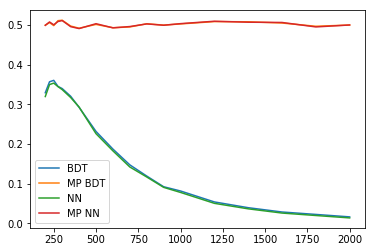

In [4]:
#print("BDT:",roc_aucs_bdt)
#print("MPBDT:",roc_aucs_mpbdt)
#print("NN:",roc_aucs_nn)
#print("MPNN:",roc_aucs_mpnn)
import matplotlib.pyplot as plt
region="INC_ge6jge4b"
#print (roc_aucs_bdt)
plt.plot(hpmasses,roc_aucs_bdt[region][0],label="BDT")
plt.plot(hpmasses,roc_aucs_mpbdt[region][0],label="MP BDT")
plt.plot(hpmasses,roc_aucs_nn[region][0],label="NN")
plt.plot(hpmasses,roc_aucs_mpnn[region][0],label="MP NN")
plt.legend()
plt.show()

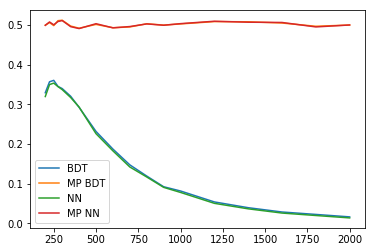

In [4]:
#print("BDT:",roc_aucs_bdt)
#print("MPBDT:",roc_aucs_mpbdt)
#print("NN:",roc_aucs_nn)
#print("MPNN:",roc_aucs_mpnn)
import matplotlib.pyplot as plt
region="INC_ge6jge4b"
#print (roc_aucs_bdt)
plt.plot(hpmasses,roc_aucs_bdt[region][0],label="BDT")
plt.plot(hpmasses,roc_aucs_mpbdt[region][0],label="MP BDT")
plt.plot(hpmasses,roc_aucs_nn[region][0],label="NN")
plt.plot(hpmasses,roc_aucs_mpnn[region][0],label="MP NN")
plt.legend()
plt.show()

In [36]:
import pandas as pd
import HpTrainingFrame
from sklearn.metrics import roc_auc_score
from keras.models import model_from_json
from joblib import load
from HpMLUtils import FeatureDivider
from HpMLFeatureNormalisation import WeightedStandardScaler

region = "5j"
subregion = "5j"
#region = "INC_ge6jge4b"
#subregion = "INC_ge6jge4b"
path = "/data/JulianGlatzer/HplusML/trainall/models/"
path = "models/"
datalabel = "train2mod0"
hpmass = 400

In [37]:
mpwss=load(path+'massparameterisedNN3_'+subregion+'_'+datalabel+'_pipe.joblib')
json_file = open(path+'massparameterisedNN3_'+subregion+'_'+datalabel+'_architecture.h5')
loaded_model_json = json_file.read()
json_file.close()
nnmpmodel = model_from_json(loaded_model_json)
nnmpmodel.load_weights(path+'massparameterisedNN3_'+subregion+'_'+datalabel+'_weights.h5')
#df_mc=pd.read_hdf('pandas_'+region+'.h5', region)
df_mc=pd.read_hdf('pandas_INC_5j3b.h5', "INC_5j3b")
htf=HpTrainingFrame.HpTrainingFrame(df_mc)

In [42]:
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=400, region=None, addMass=True)

In [43]:
print(len(y_train))
print(X_train.hpmass.unique(), y_train.unique())
print(y_train[X_train.hpmass==400].unique())
X_train.hpmass=400
print(X_train.hpmass.unique())
fd=FeatureDivider("hpmass")
wss=WeightedStandardScaler()
fd.fit(X_train,X_train.hpmass,sample_weight=w_train)
#fd.fit(X_test,X_test.hpmass,sample_weight=w_test)
#X_tr,y_tr, w_tr = fd.transform(X_train,y_train,sample_weight=w_train)#
X_tr,y_tr, w_tr = fd.transform(X_test,y_test,sample_weight=w_test)
print(X_tr.shape)
#X_tr=X_tr.drop(["hpmass"],axis=1)
print(X_tr.columns)
wss.fit(X_tr,y_tr,sample_weight=w_tr)
X_tr,y_tr,w_tr = wss.transform(X_tr, y_tr, sample_weight=w_tr)
print (X_tr.shape, X_tr.columns)

166234
[ -1 400] [0 1]
[1]
[400]
(166670, 27)
Index(['nJets', 'nBTags_70', 'pT_jet1', 'Mbb_MindR_70', 'pT_jet5', 'H1_all',
       'dRbb_avg_70', 'dRlepbb_MindR_70', 'Muu_MindR_70', 'HT_jets',
       'Mbb_MaxPt_70', 'Mbb_MaxM_70', 'Mjjj_MaxPt', 'Centrality_all', 'hpmass',
       'pT_jet1divhpmass', 'Mbb_MindR_70divhpmass', 'pT_jet5divhpmass',
       'H1_alldivhpmass', 'dRbb_avg_70divhpmass', 'dRlepbb_MindR_70divhpmass',
       'Muu_MindR_70divhpmass', 'HT_jetsdivhpmass', 'Mbb_MaxPt_70divhpmass',
       'Mbb_MaxM_70divhpmass', 'Mjjj_MaxPtdivhpmass',
       'Centrality_alldivhpmass'],
      dtype='object')
(166670, 27) [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26]
(166670, 25) Index(['pT_jet1', 'Mbb_MindR_70', 'pT_jet5', 'H1_all', 'dRbb_avg_70',
       'dRlepbb_MindR_70', 'Muu_MindR_70', 'HT_jets', 'Mbb_MaxPt_70',
       'Mbb_MaxM_70', 'Mjjj_MaxPt', 'Centrality_all', 'hpmass',
       'pT_jet1divhpmass', 'Mbb_MindR_70divhpmass', 'pT_jet5divhpmass',
       'H

In [32]:
#print(X_tr.shape, X_tr.mean(axis=0), X_tr.var(axis=0), X_tr.hpmass.unique())
print(X_tr.hpmass[y_tr>0.5].unique(), X_tr.hpmass[y_tr<0.5].unique())
#X_tr.hpmass=X_tr.hpmass[y_tr>0.5].unique()[0]

[10.77568179] [-0.09280155]


In [34]:
X_tr.hpmass=X_tr[y_tr>0.5].hpmass.unique()[0]

In [35]:
roc_auc_nn=1.-roc_auc_score(y_tr, nnmpmodel.predict(X_tr), sample_weight=w_tr)
print (roc_auc_nn)

ValueError: Error when checking input: expected dense_4_input to have shape (27,) but got array with shape (25,)

In [7]:
y_train_pred = nnmpmodel.predict(X_tr).ravel()

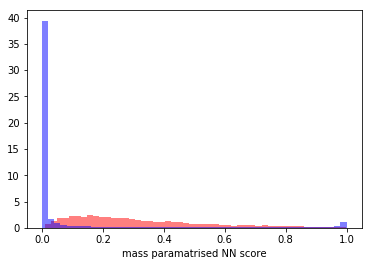

In [9]:
import matplotlib.pyplot as plt
bins = 50
plt.hist(y_train_pred[y_tr>0.5].ravel(),alpha=0.5,color='r',bins=bins, density=True)
plt.hist(y_train_pred[y_tr<0.5].ravel(),alpha=0.5,color='b',bins=bins, density=True)
plt.xlabel("mass paramatrised NN score")
plt.show()

0.7923786444631433


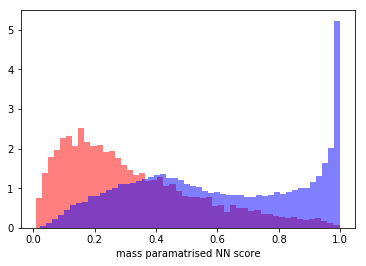

In [24]:
import matplotlib.pyplot as plt
bins = 50
y_train_pred = nnmpmodel.predict(X_tr).ravel()
roc_auc_nn=1.-roc_auc_score(y_tr, nnmpmodel.predict(X_tr), sample_weight=w_tr)
print (roc_auc_nn)
plt.hist(y_train_pred[y_tr>0.5].ravel(),alpha=0.5,color='r',bins=bins, density=True)
plt.hist(y_train_pred[y_tr<0.5].ravel(),alpha=0.5,color='b',bins=bins, density=True)
plt.xlabel("mass paramatrised NN score")
plt.show()

### Standard way?

In [25]:
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=400, region=None, addMass=True)

In [27]:
print( X_train.shape)
#X_test["hpmass"]=400
print(X_test.shape,X_test.mean(axis=0),X_test.var(axis=0),X_test.hpmass.unique())
X_testnn,y_testnn,w_testnn =mpwss.transform(X_test,y_test,sample_weight=w_test)
X_testnn.hpmass=X_testnn[y_testnn>0.5].hpmass.unique()[0]
print(X_testnn.shape,X_testnn.mean(axis=0),X_testnn.var(axis=0),X_testnn.hpmass.unique())
roc_auc_nn=1.-roc_auc_score(y_test, nnmpmodel.predict(X_testnn), sample_weight=w_test)
print (roc_auc_nn)

(90493, 15)
(91154, 15) nJets                    7.269588
nBTags_70                4.071330
pT_jet1             196124.156014
Mbb_MindR_70         84016.246827
pT_jet5              56774.014831
H1_all                   0.244329
dRbb_avg_70              2.159917
dRlepbb_MindR_70         2.169747
Muu_MindR_70        103075.786597
HT_jets             645272.928949
Mbb_MaxPt_70        151139.178721
Mbb_MaxM_70         298948.991466
Mjjj_MaxPt          299379.812609
Centrality_all           0.603531
hpmass                  27.356912
dtype: float64 nJets               1.787644e+00
nBTags_70           7.563342e-02
pT_jet1             1.386138e+10
Mbb_MindR_70        2.077790e+09
pT_jet5             5.820995e+08
H1_all              4.970727e-02
dRbb_avg_70         1.224668e-01
dRlepbb_MindR_70    7.469958e-01
Muu_MindR_70        1.133940e+10
HT_jets             8.622986e+10
Mbb_MaxPt_70        1.288457e+10
Mbb_MaxM_70         3.015329e+10
Mjjj_MaxPt          4.929371e+10
Centrality_all      1.